In [46]:
#Libraries

install.packages(c(
  "dplyr",
  "tidyr",
  "purrr",
  "ggplot2",
  "patchwork",
  "knitr",
  "glue",
  "ResourceSelection",
 "tidyverse",
  "rsample",
   "pROC",
  "caret"
))

In [47]:
library(dplyr)
library(tidyr)
library(purrr)
library(ggplot2)
library(patchwork)
library(knitr)
library(glue)
library(rsample)
library(tidyverse)
library(MASS)
library(broom)
library(pROC)
library(caret)

In [48]:
# Upload the data

csv_url <- "https://raw.githubusercontent.com/houraniiiii/cpmqhai/refs/heads/main/HFdemo.csv"

CHF_data <- read.csv(csv_url)

print(head(CHF_data))

  age gender weight height acute_coronary_syndrome cardiac_arrest
1  76      1   76.2    166                       1              0
2  57      1   96.0    157                       0              0
3  56      0   91.0    185                       0              0
4  75      1   93.0    168                       0              0
5  47      0  127.0    183                       0              0
6  66      0   91.0    173                       1              0
  atrial_fibrillation mitral_valve_disease aortic_valve_disease
1                   0                    1                    0
2                   0                    0                    0
3                   0                    0                    1
4                   1                    0                    0
5                   1                    0                    0
6                   1                    1                    0
  pulmonary_hypertension hypertension peripheral_vascular_disease
1                      0

In [49]:
# Data inspection    ---- Tables

# ══════════════════════════════════════════════════════════════════════════════
#  1.  DETECT BINARY vs CONTINUOUS
# ══════════════════════════════════════════════════════════════════════════════
binary_cols <- names(CHF_data)[
  sapply(CHF_data, function(x) {
    (is.numeric(x) && all(na.omit(x) %in% c(0, 1))) ||
      (is.factor(x)  && all(levels(x) %in% c("0","1")))
  })
]

continuous_cols <- names(CHF_data)[
  sapply(CHF_data, is.numeric) & !(names(CHF_data) %in% binary_cols)
]

# ══════════════════════════════════════════════════════════════════════════════
#  2.  SUMMARY TABLES  ----------------------------------------------------------
# ══════════════════════════════════════════════════════════════════════════════
## 2a. Continuous
cont_summary <- purrr::map_dfr(continuous_cols, function(col) {
  v <- CHF_data[[col]]
  tibble(
    variable = col,
    median   = median(v, na.rm = TRUE),
    IQR      = IQR(v,    na.rm = TRUE),
    mean     = mean(v,   na.rm = TRUE),
    sd       = sd(v,     na.rm = TRUE),
    min      = min(v,    na.rm = TRUE),
    max      = max(v,    na.rm = TRUE),
    na_n     = sum(is.na(v)),
    na_pct   = mean(is.na(v)) * 100
  )
}) %>%

  mutate(
    across(c(median:IQR, mean:sd, min:max, na_pct), ~ round(.x, 1))
  )

## 2b. Binary ──────────────────────────────────────────────────────────────────
bin_summary <- purrr::map_dfr(binary_cols, function(col) {
  v <- CHF_data[[col]]
  tibble(
    variable = col,
    n0   = sum(v %in% c(0, "0"), na.rm = TRUE),
    pct0 = mean(v %in% c(0, "0"), na.rm = TRUE) * 100,
    n1   = sum(v %in% c(1, "1"), na.rm = TRUE),
    pct1 = mean(v %in% c(1, "1"), na.rm = TRUE) * 100
  )
}) %>%

  mutate(
    across(c(pct0, pct1), ~ round(.x, 1))
  )

knitr::kable(cont_summary, caption = "Continuous variables")
knitr::kable(bin_summary,  caption = "Binary variables")



Table: Continuous variables

|variable                 | median|    IQR|   mean|      sd|     min|     max| na_n| na_pct|
|:------------------------|------:|------:|------:|-------:|-------:|-------:|----:|------:|
|age                      |   68.0|   14.0|   65.8|    11.0|    18.0|    80.0|    0|      0|
|weight                   |   85.0|   30.5|   88.8|    27.3|    30.7|   345.0|    0|      0|
|height                   |  170.0|   15.0|  169.9|    10.8|   132.0|   220.0|    0|      0|
|troponin_t               |    0.2|    0.9|    1.0|     3.0|    -1.5|    52.4|    0|      0|
|nt_pro_bnp               | 5168.0| 8905.0| 9019.9| 11060.4| -1013.9| 68886.0|    0|      0|
|hematocrit               |   30.6|    7.6|   31.6|     5.7|    14.4|    63.0|    0|      0|
|hemoglobin               |  100.0|   26.0|  103.2|    19.3|    39.7|   194.0|    0|      0|
|MCH                      |   29.9|    3.0|   29.7|     2.6|    17.1|    42.1|    0|      0|
|MCHC                     |   32.8|    



Table: Binary variables

|variable                            |   n0| pct0|   n1| pct1|
|:-----------------------------------|----:|----:|----:|----:|
|gender                              | 3669| 60.8| 2362| 39.2|
|acute_coronary_syndrome             | 4431| 73.5| 1600| 26.5|
|cardiac_arrest                      | 5784| 95.9|  247|  4.1|
|atrial_fibrillation                 | 3360| 55.7| 2671| 44.3|
|mitral_valve_disease                | 4796| 79.5| 1235| 20.5|
|aortic_valve_disease                | 5108| 84.7|  923| 15.3|
|pulmonary_hypertension              | 4971| 82.4| 1060| 17.6|
|hypertension                        | 1415| 23.5| 4616| 76.5|
|peripheral_vascular_disease         | 4023| 66.7| 2008| 33.3|
|hyperlipidemia                      | 5628| 93.3|  403|  6.7|
|copd                                | 4720| 78.3| 1311| 21.7|
|acute_ischemic_stroke               | 5761| 95.5|  270|  4.5|
|malignant_cancer                    | 5490| 91.0|  541|  9.0|
|metastatic_solid_tumor     

In [50]:
# Data inspection    ---- Plots

options(repr.plot.width = 22, repr.plot.height = 6)
outcome_var <- "mortality_90d"
binary_cols_plot <- setdiff(binary_cols, outcome_var)
CHF_data[[outcome_var]] <- factor(CHF_data[[outcome_var]], levels = c(0, 1))

# ══════════════════════════════════════════════════════════════════════════════
#  3. PLOTTING HELPERS
# ══════════════════════════════════════════════════════════════════════════════
plot_box_cont <- function(df, var, outcome) {
  p_full <- ggplot(df, aes(y = .data[[var]])) +
    geom_boxplot(na.rm = TRUE, fill = "skyblue", alpha = 0.7, outlier.shape = 21) +
    theme_bw(base_size = 14) +
    labs(title = glue("{var} – full cohort"), x = NULL, y = var)

  p_group <- ggplot(df, aes(x = .data[[outcome]], y = .data[[var]], fill = .data[[outcome]])) +
    geom_boxplot(na.rm = TRUE, alpha = 0.7, outlier.shape = 21) +
    theme_bw(base_size = 14) +
    scale_fill_brewer(palette = "Set2", name = outcome) +
    labs(title = glue("{var} by {outcome}"), x = outcome, y = var) +
    theme(legend.position = "top")

  p_full + p_group + plot_layout(guides = "collect")
}

plot_hist_cont <- function(df, var, outcome) {
  p_full <- ggplot(df, aes(x = .data[[var]])) +
    geom_histogram(bins = 30, na.rm = TRUE, fill = "steelblue", color = "black", alpha = 0.7) +
    theme_bw(base_size = 14) +
    labs(title = glue("{var} – full cohort"), x = var, y = "count")

  p_group <- ggplot(df, aes(x = .data[[var]], fill = .data[[outcome]])) +
    geom_histogram(bins = 30, na.rm = TRUE, color = "black", alpha = 0.7, position = "identity") +
    facet_wrap(vars(.data[[outcome]]), nrow = 1, scales = "free_y") +
    theme_bw(base_size = 14) +
    scale_fill_brewer(palette = "Set2", name = outcome) +
    labs(title = glue("{var} by {outcome}"), x = var, y = "count") +
    theme(legend.position = "top")

  p_full + p_group + plot_layout(guides = "collect")
}

plot_binary_bar <- function(df, var, outcome) {
  df_plot <- df %>%
    mutate("{var}" := factor(.data[[var]], levels = c(0, 1)))

  p_full <- ggplot(df_plot, aes(x = .data[[var]], fill = .data[[var]])) +
    geom_bar(alpha = 0.8, color = "black") +
    theme_bw(base_size = 14) +
    scale_fill_brewer(palette = "Pastel1", name = var) +
    guides(fill = "none") +
    labs(title = glue("{var} – full cohort"), x = var, y = "count")

  p_group <- ggplot(df_plot, aes(x = .data[[var]], fill = .data[[var]])) +
    geom_bar(alpha = 0.8, color = "black") +
    facet_wrap(vars(.data[[outcome]]), nrow = 1, scales = "free_y") +
    theme_bw(base_size = 14) +
    scale_fill_brewer(palette = "Pastel1", name = var) +
    guides(fill = "none") +
    labs(title = glue("{var} by {outcome}"), x = var, y = "count")

  p_full + p_group + plot_layout(guides = "collect")
}

# # ══════════════════════════════════════════════════════════════════════════════
# #  4. GENERATE & DISPLAY PLOTS                                                 #
# # ══════════════════════════════════════════════════════════════════════════════
#  for (v in continuous_cols) {
#   print(plot_box_cont(CHF_data, v, outcome_var))
#  print(plot_hist_cont(CHF_data, v, outcome_var))
#  }

#  for (v in binary_cols_plot) {
#  print(plot_binary_bar(CHF_data, v, outcome_var))
# }

In [51]:
#Outliers removal
###############################################################################
# WINSORISE continuous variables at 1 % / 99 %
###############################################################################

winsorise_vec <- function(x, probs = c(0.01, 0.99)) {
  if (all(is.na(x))) return(x)                 # leave all-NA columns untouched
  qs <- quantile(x, probs = probs, na.rm = TRUE, names = FALSE)
  pmin(pmax(x, qs[1]), qs[2])                  # clamp to the two quantiles
}

CHF_data_winsorised <- CHF_data %>%
  mutate(across(all_of(continuous_cols), winsorise_vec))


###############################################################################
# Data inspection post winsorisation    ---- Plots
plot_box_cont <- function(df, var, outcome) {
  p_full <- ggplot(df, aes(y = .data[[var]])) +
    geom_boxplot(na.rm = TRUE, fill = "skyblue", alpha = 0.7, outlier.shape = 21) +
    theme_bw(base_size = 14) +
    labs(title = glue("{var} – full cohort"), x = NULL, y = var)

  p_group <- ggplot(df, aes(x = .data[[outcome]], y = .data[[var]], fill = .data[[outcome]])) +
    geom_boxplot(na.rm = TRUE, alpha = 0.7, outlier.shape = 21) +
    theme_bw(base_size = 14) +
    scale_fill_brewer(palette = "Set2", name = outcome) +
    labs(title = glue("{var} by {outcome}"), x = outcome, y = var) +
    theme(legend.position = "top")

  p_full + p_group + plot_layout(guides = "collect")
}

plot_hist_cont <- function(df, var, outcome) {
  p_full <- ggplot(df, aes(x = .data[[var]])) +
    geom_histogram(bins = 30, na.rm = TRUE, fill = "steelblue", color = "black", alpha = 0.7) +
    theme_bw(base_size = 14) +
    labs(title = glue("{var} – full cohort"), x = var, y = "count")

  p_group <- ggplot(df, aes(x = .data[[var]], fill = .data[[outcome]])) +
    geom_histogram(bins = 30, na.rm = TRUE, color = "black", alpha = 0.7, position = "identity") +
    facet_wrap(vars(.data[[outcome]]), nrow = 1, scales = "free_y") +
    theme_bw(base_size = 14) +
    scale_fill_brewer(palette = "Set2", name = outcome) +
    labs(title = glue("{var} by {outcome}"), x = var, y = "count") +
    theme(legend.position = "top")

  p_full + p_group + plot_layout(guides = "collect")
}

#  for (v in continuous_cols) {
#   print(plot_box_cont(CHF_data_winsorised, v, outcome_var))
#  print(plot_hist_cont(CHF_data_winsorised, v, outcome_var))
#  }

In [52]:
# Data inspection    ---- Tables

cont_summary <- purrr::map_dfr(continuous_cols, function(col) {
  v <- CHF_data_winsorised[[col]]
  tibble(
    variable = col,
    median   = median(v, na.rm = TRUE),
    IQR      = IQR(v,    na.rm = TRUE),
    mean     = mean(v,   na.rm = TRUE),
    sd       = sd(v,     na.rm = TRUE),
    min      = min(v,    na.rm = TRUE),
    max      = max(v,    na.rm = TRUE),
    na_n     = sum(is.na(v)),
    na_pct   = mean(is.na(v)) * 100
  )
}) %>%

  mutate(
    across(c(median:IQR, mean:sd, min:max, na_pct), ~ round(.x, 1))
  )


knitr::kable(cont_summary, caption = "Continuous variables")



Table: Continuous variables

|variable                 | median|    IQR|   mean|      sd|    min|     max| na_n| na_pct|
|:------------------------|------:|------:|------:|-------:|------:|-------:|----:|------:|
|age                      |   68.0|   14.0|   65.9|    10.9|   30.3|    80.0|    0|      0|
|weight                   |   85.0|   30.5|   88.5|    25.4|   45.0|   180.9|    0|      0|
|height                   |  170.0|   15.0|  169.9|    10.6|  145.0|   193.0|    0|      0|
|troponin_t               |    0.2|    0.9|    1.0|     2.5|   -1.3|    15.8|    0|      0|
|nt_pro_bnp               | 5168.0| 8905.0| 8951.8| 10741.1| -663.7| 53436.0|    0|      0|
|hematocrit               |   30.6|    7.6|   31.6|     5.5|   22.2|    47.2|    0|      0|
|hemoglobin               |  100.0|   26.0|  103.2|    18.9|   71.5|   156.2|    0|      0|
|MCH                      |   29.9|    3.0|   29.7|     2.5|   22.0|    35.5|    0|      0|
|MCHC                     |   32.8|    2.0|   32.

In [53]:
###############################################################################
# 0.  One-time reproducibility switches
###############################################################################
set.seed(2025)                 # global seed
RNGkind("L'Ecuyer-CMRG")       # platform-independent RNG
options(dplyr.summarise.inform = FALSE)


In [54]:
###############################################################################
# 1.  Train-test split (80 / 20, stratified)
###############################################################################
set.seed(202501)   # split reproducibility

split_obj  <- initial_split(CHF_data_winsorised,
                            prop   = 0.80,
                            strata = !!sym(outcome_var))
train_data <- training(split_obj)
test_data  <- testing(split_obj)

continuous_cols <- setdiff(continuous_cols, outcome_var)


In [55]:
###############################################################################
# 3.  Integer class weights
###############################################################################
# class counts in TRAIN
n1 <- sum(train_data[[outcome_var]] == 1)
n0 <- sum(train_data[[outcome_var]] == 0)

# raw inverse-prevalence weights
w1_raw <- (n0 + n1) / (2 * n1)   # positive class
w0_raw <- (n0 + n1) / (2 * n0)   # negative class

# ---- NEW: scale so the smaller weight is exactly 1, then round --------------
scale_factor <- 1 / min(w1_raw, w0_raw)
w1_int <- round(w1_raw * scale_factor)
w0_int <- round(w0_raw * scale_factor)

train_data <- train_data %>%
  mutate(case_wt = if_else(!!sym(outcome_var) == 1, w1_int, w0_int))


In [56]:
###############################################################################
# 4.  Clinically selected predictors
###############################################################################
# ---------------------------------------------------------------------------
# Chosen a-priori by clinical relevance to 90-day mortality in acute / chronic
# heart-failure admissions.
#   • 7 continuous markers of age, cardiac strain, renal & metabolic status,
#     haemodynamics and perfusion
#   • 8 binary indicators of comorbidity and acute severity / therapy
# ---------------------------------------------------------------------------
selected <- c(
  # continuous
  "age",
  "creatinine",
  "lactate",
  "systolic_blood_pressure",
  "heart_rate",
  # binary
  "gender",
  "malignant_cancer",
  "shock",
  "mechanical_ventilation",
  "vasopressor_use"
)

message("Predictors in the model (n = ", length(selected), "): ",
        paste(selected, collapse = ", "))

# Build final weighted GLM
final_form <- reformulate(selected, outcome_var)

glm_final <- glm(final_form,
                 data    = train_data,
                 family  = binomial(link = "logit"),
                 weights = case_wt)

summary(glm_final)

Predictors in the model (n = 10): age, creatinine, lactate, systolic_blood_pressure, heart_rate, gender, malignant_cancer, shock, mechanical_ventilation, vasopressor_use




Call:
glm(formula = final_form, family = binomial(link = "logit"), 
    data = train_data, weights = case_wt)

Coefficients:
                         Estimate Std. Error z value Pr(>|z|)    
(Intercept)             -4.838940   0.370096 -13.075  < 2e-16 ***
age                      0.041598   0.002619  15.886  < 2e-16 ***
creatinine               0.120216   0.012994   9.251  < 2e-16 ***
lactate                  0.136072   0.012218  11.137  < 2e-16 ***
systolic_blood_pressure -0.004867   0.001843  -2.640 0.008282 ** 
heart_rate               0.010908   0.001883   5.792 6.97e-09 ***
gender                   0.231569   0.052735   4.391 1.13e-05 ***
malignant_cancer         1.163705   0.083486  13.939  < 2e-16 ***
shock                    1.171527   0.064272  18.228  < 2e-16 ***
mechanical_ventilation   0.428007   0.100205   4.271 1.94e-05 ***
vasopressor_use         -0.235686   0.062265  -3.785 0.000154 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion pa

In [57]:
###############################################################################
# 5.  Discrimination metrics on TRAIN and TEST
###############################################################################
set.seed(202505)

get_metrics <- function(obs, prob, cut = 0.5) {
  pred <- ifelse(prob >= cut, 1, 0)
  cm   <- confusionMatrix(factor(pred, levels = c(0,1)),
                          factor(obs,  levels = c(0,1)))
  tibble(
    AUC         = as.numeric(pROC::auc(obs, prob, quiet = TRUE)),  # <<< added quiet
    Sensitivity = cm$byClass["Sensitivity"],
    Specificity = cm$byClass["Specificity"],
    Precision   = cm$byClass["Pos Pred Value"],
    Recall      = cm$byClass["Sensitivity"],
    Accuracy    = cm$overall["Accuracy"]
  )
}


train_prob  <- predict(glm_final, type = "response")
test_prob   <- predict(glm_final, newdata = test_data, type = "response")

perf_tbl <- bind_rows(
  train = get_metrics(train_data[[outcome_var]], train_prob),
  test  = get_metrics(test_data [[outcome_var]], test_prob),
  .id = "set"
)

knitr::kable(perf_tbl, digits = 3,
             caption = "Model discrimination (cut-off = 0.50)")




Table: Model discrimination (cut-off = 0.50)

|set   |   AUC| Sensitivity| Specificity| Precision| Recall| Accuracy|
|:-----|-----:|-----------:|-----------:|---------:|------:|--------:|
|train | 0.752|       0.760|       0.617|     0.895|  0.760|    0.733|
|test  | 0.773|       0.767|       0.634|     0.901|  0.767|    0.742|

In [58]:
###############################################################################
# 6.  100-bootstrap internal validation (optimism-corrected metrics)
###############################################################################
set.seed(202506)                     # reproducible resamples
library(purrr)
library(dplyr, warn.conflicts = FALSE)   # re-establish dplyr::select

B <- 100

boot_results <- map_dfr(seq_len(B), function(i) {

  idx        <- sample.int(nrow(train_data), replace = TRUE)
  boot_train <- train_data[idx, ]

  boot_fit <- glm(glm_final$formula,
                  data    = boot_train,
                  family  = binomial,
                  weights = case_wt)

  bind_rows(
    apparent      = get_metrics(boot_train[[outcome_var]],
                                predict(boot_fit, type = "response")),
    test_on_train = get_metrics(train_data[[outcome_var]],
                                predict(boot_fit, newdata = train_data,
                                        type = "response")),
    .id = "type"
  ) %>% mutate(iter = i)
})

optim_tbl <- boot_results %>%
  group_by(type) %>%
  summarise(across(AUC:Accuracy, mean), .groups = "drop") %>%
  tidyr::pivot_wider(names_from = type, values_from = AUC:Accuracy) %>%
  mutate(across(ends_with("_apparent"),
                ~ .x - ( .x - get(sub("_apparent", "_test_on_train", cur_column())) ),
                .names = "{sub('_apparent', '', .col)}_corrected")) %>%
  dplyr::select(ends_with("_corrected")) %>%
  mutate(set = "optimism-corrected") %>%
  relocate(set)

knitr::kable(optim_tbl, digits = 3,
             caption = "Optimism-corrected performance (B = 100)")




Table: Optimism-corrected performance (B = 100)

|set                | AUC_corrected| Sensitivity_corrected| Specificity_corrected| Precision_corrected| Recall_corrected| Accuracy_corrected|
|:------------------|-------------:|---------------------:|---------------------:|-------------------:|----------------:|------------------:|
|optimism-corrected |          0.75|                 0.757|                 0.612|               0.894|            0.757|              0.729|


	Hosmer and Lemeshow goodness of fit (GOF) test

data:  obs_num, train_prob
X-squared = 14884, df = 8, p-value < 2.2e-16



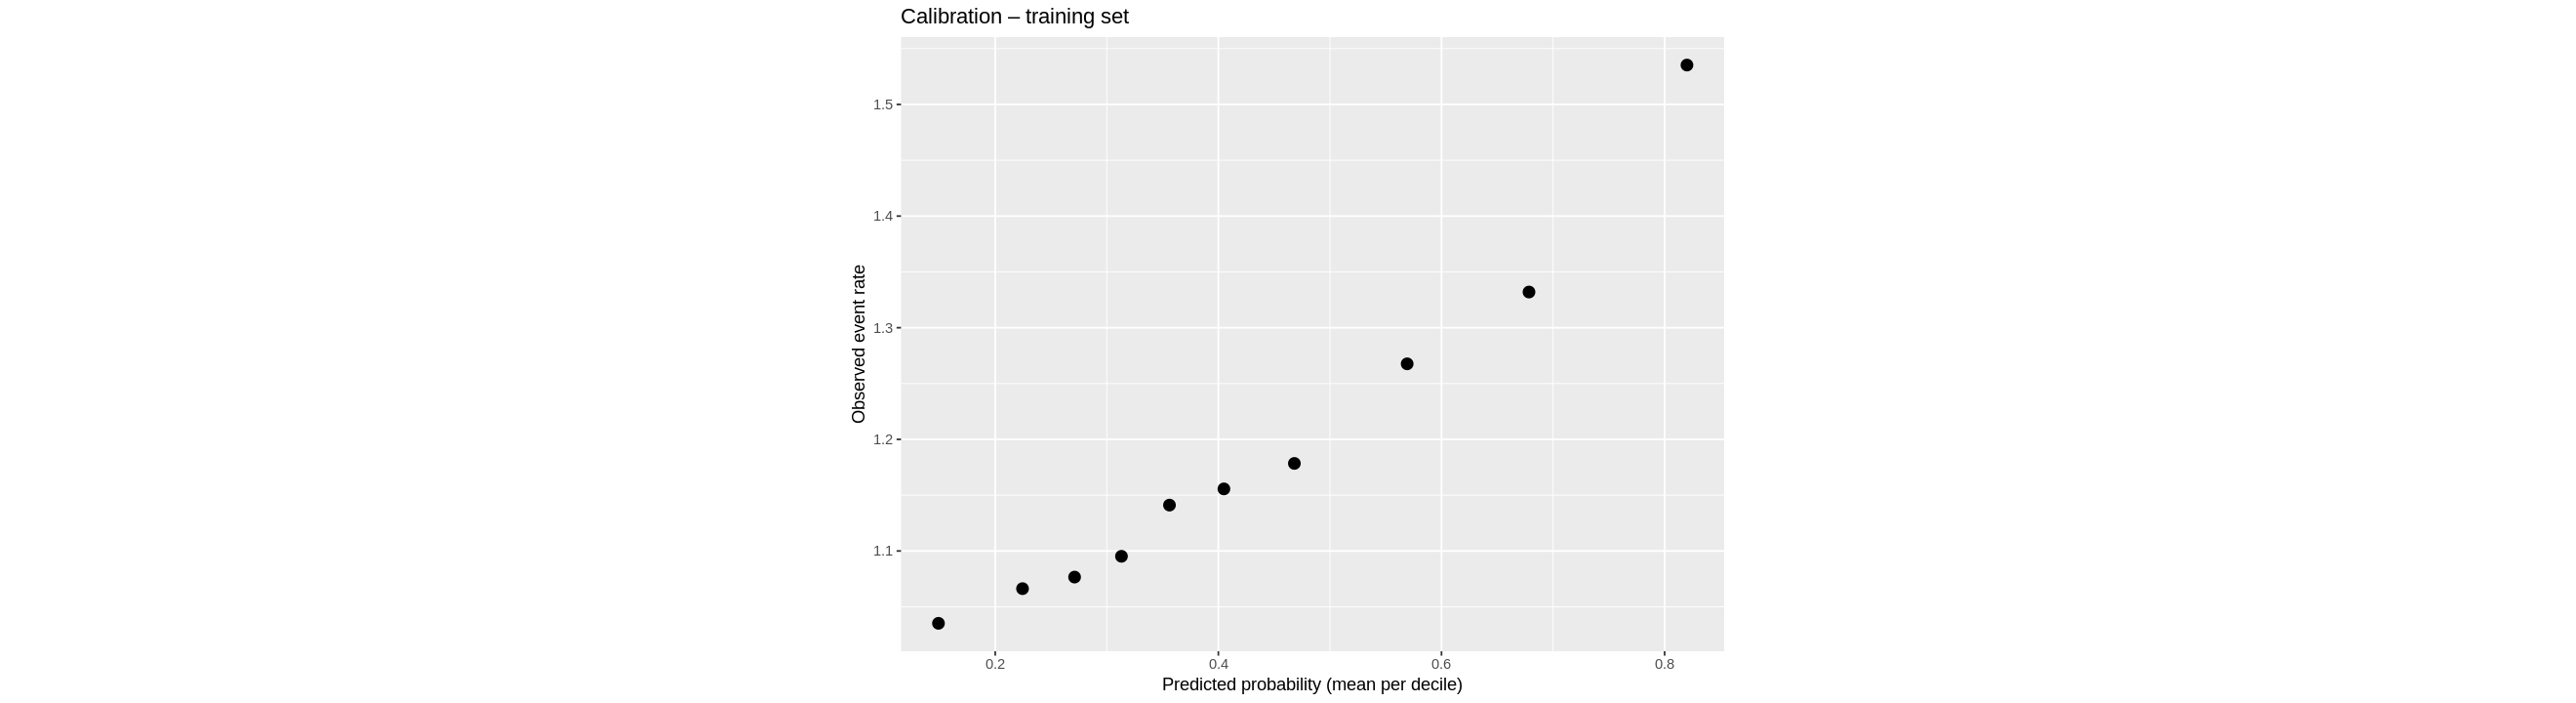

In [59]:
###############################################################################
# 7.  Calibration: Hosmer–Lemeshow test + plot  (robust to factor outcome)
###############################################################################
library(ResourceSelection)
library(dplyr, warn.conflicts = FALSE)

# ── 7·1  Numeric outcome vector ------------------------------------------------
obs_num <- train_data %>%
  pull(!!sym(outcome_var)) %>%
  as.numeric(as.character(.))          # 0/1 numeric

hl <- hoslem.test(obs_num, train_prob, g = 10)
print(hl)

# ── 7·2  Calibration plot (deciles) -------------------------------------------
train_data %>%
  mutate(prob        = train_prob,
         outcome_num = obs_num,
         decile      = ntile(prob, 10)) %>%
  group_by(decile) %>%
  summarise(obs  = mean(outcome_num),
            pred = mean(prob), .groups = "drop") %>%
  ggplot(aes(pred, obs)) +
  geom_point(size = 3) +
  geom_abline(linetype = 2) +
  coord_equal() +
  labs(title = "Calibration – training set",
       x = "Predicted probability (mean per decile)",
       y = "Observed event rate")


In [60]:
###############################################################################
# 8.  Coefficient table with OR and 95 % CI
###############################################################################
library(broom)
library(dplyr, warn.conflicts = FALSE)

coef_tbl <- tidy(glm_final) %>%
  mutate(
    OR      = exp(estimate),
    CI_low  = exp(estimate - 1.96 * std.error),
    CI_high = exp(estimate + 1.96 * std.error)
  ) %>%
  dplyr::select(term, estimate, OR, CI_low, CI_high, p.value) %>%
  mutate(
    across(c(estimate, OR, CI_low, CI_high, p.value), \(x) round(x, 3))
  ) %>%
  dplyr::arrange(p.value)

knitr::kable(
  coef_tbl,
  caption = "Final model coefficients (log-odds) and odds ratios ± 95 % CI"
)




Table: Final model coefficients (log-odds) and odds ratios ± 95 % CI

|term                    | estimate|    OR| CI_low| CI_high| p.value|
|:-----------------------|--------:|-----:|------:|-------:|-------:|
|(Intercept)             |   -4.839| 0.008|  0.004|   0.016|   0.000|
|age                     |    0.042| 1.042|  1.037|   1.048|   0.000|
|creatinine              |    0.120| 1.128|  1.099|   1.157|   0.000|
|lactate                 |    0.136| 1.146|  1.119|   1.174|   0.000|
|heart_rate              |    0.011| 1.011|  1.007|   1.015|   0.000|
|gender                  |    0.232| 1.261|  1.137|   1.398|   0.000|
|malignant_cancer        |    1.164| 3.202|  2.718|   3.771|   0.000|
|shock                   |    1.172| 3.227|  2.845|   3.660|   0.000|
|mechanical_ventilation  |    0.428| 1.534|  1.261|   1.867|   0.000|
|vasopressor_use         |   -0.236| 0.790|  0.699|   0.893|   0.000|
|systolic_blood_pressure |   -0.005| 0.995|  0.992|   0.999|   0.008|

In [61]:
###############################################################################
# 9.  Final prediction formula (human-readable)
###############################################################################
coef_vec <- coef(glm_final)

# Convert into a readable equation string
eqn <- glue::glue_collapse(
  purrr::imap_chr(coef_vec, ~ {
    b <- round(.x, 4)
    if (.y == "(Intercept)") glue::glue("{b}")
    else glue::glue("{ifelse(b >= 0, '+', '')}{b} * {.y}")
  }),
  sep = " "
)

cat(
  "Logit(p)  = ", eqn, "\n",
  "Probability = 1 / (1 + exp( - Logit(p) ))\n", sep = ""
)


Logit(p)  = -4.8389 +0.0416 * age +0.1202 * creatinine +0.1361 * lactate -0.0049 * systolic_blood_pressure +0.0109 * heart_rate +0.2316 * gender +1.1637 * malignant_cancer +1.1715 * shock +0.428 * mechanical_ventilation -0.2357 * vasopressor_use
Probability = 1 / (1 + exp( - Logit(p) ))


## TRIPOD (2015) – Transparent Reporting of a multivariable prediction model for Individual Prognosis Or Diagnosis  

The original TRIPOD Statement lists **22 items** grouped in Title/Abstract, Introduction, Methods, Results, Discussion and Other information.  
Key points to tick off for every CPM paper/notebook:  

| Section | Must-report items |
|---------|------------------|
| **Methods** | exact study design, setting, dates, candidate predictors, outcome definition & timing, handling of missing data, model-building procedures, internal validation method |
| **Results** | flow diagram of participants, baseline characteristics (Table 1), final model (all β-coefficients + intercept), full performance (discrimination, calibration) |
| **Discussion** | strengths/limitations, comparison with other models, clinical use, reproducible code/data availability |

*Resources:* TRIPOD explanation & checklist PDFs are hosted on the TRIPOD website.


## TRIPOD + AI (2024) – tailored for ML/AI prediction models  

The extension keeps all 22 core items but **adds clarity for ML-specific choices**:  

* data pre-processing & feature engineering steps  
* optimiser, hyper-parameter search, hardware, software versions  
* over-sampling / class-imbalance techniques  
* explainability approach provided (e.g. SHAP, ICE)  
* external test data provenance  

Make sure your CPM notebook cites TRIPOD + AI when using tree-based ensembles, neural networks, or any automated feature-selection pipeline.


## PROBAST – Prediction model Risk Of Bias ASsessment Tool  

A 20-item checklist across four domains:

1. **Participants** – spectrum, inclusion/exclusion, setting  
2. **Predictors** – definition, timing, blinding  
3. **Outcome** – definition, timing, blinding  
4. **Analysis** – sample size, handling of missing data, over-fitting, performance measures  

For every new CPM (development **and** validation) complete a PROBAST table; low-risk studies carry more weight for adoption.


## FAIR principles and open artefacts  

* **Findable** – DOI for data & code; rich metadata  
* **Accessible** – public repository or controlled-access pathway  
* **Interoperable** – non-proprietary formats (CSV, JSON, RDS)  
* **Reusable** – clear licence (MIT, CC-BY), versioning, detailed README  

Publishing the notebook, cleaned data dictionary, and model weights under FAIR guidelines accelerates peer review and downstream appraisal.

## External validation ➜ Updating ➜ Impact evaluation  

1. **External validation** – new cohort, same definitions → report c-statistic, calibration-slope, decision-curve  
2. **Model updating** – if calibration-slope ≠ 1, apply intercept/slope update or refit selected predictors  
3. **Impact study** – cluster-RCT or before-after study to show change in clinician behaviour/patient outcomes  

Moons *et al.* (2012) outline this three-step lifecycle for clinical prediction models.